# 均值回归_Mean Reverting Strategy

In [19]:
#先引入后面可能用到的包（package）
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime,timedelta
import seaborn as sns  
sns.set()  
%matplotlib inline   

#正常显示画图时出现的中文和负号
from pylab import mpl
mpl.rcParams['font.sans-serif']=['SimHei']
mpl.rcParams['axes.unicode_minus']=False

In [20]:
#使用tushare获取交易数据
#设置token
import tushare as ts 
token='e0eeb08befd1f07516df2cbf9cbd58663f77fd72f92a04f290291c9d'
ts.set_token(token)
pro=ts.pro_api(token)
#pro=ts.pro_api(token)
index={'上证综指': '000001.SH','深证成指': '399001.SZ',
        '沪深300': '000300.SH','创业板指': '399006.SZ',
        '上证50': '000016.SH','中证500': '000905.SH',
        '中小板指': '399005.SZ','上证180': '000010.SH'}
#获取当前交易的股票代码和名称
def get_code():
    df = pro.stock_basic(exchange='', list_status='L')
    codes=df.ts_code.values
    names=df.name.values
    stock=dict(zip(names,codes))
    #合并指数和个股成一个字典
    stocks=dict(stock,**index)
    return stocks    

#获取行情数据
def get_data(stock,start='20151009',end=''):
    #如果代码在字典index里，则取的是指数数据
    code=get_code()[stock]
    if code in index.values():
        df=ts.pro_bar(ts_code=code,asset='I',start_date=start, end_date=end)
    #否则取的是个股数据
    else:
        df=ts.pro_bar(ts_code=code, adj='qfq',start_date=start, end_date=end)
    #将交易日期设置为索引值
    df.index=pd.to_datetime(df.trade_date)
    df=df.sort_index()
    return df

# 策略思想

均值回归策略应用了股市投资中经典的高抛低吸思想，该类型策略一般在震荡市中表现优异；
但是在单边趋势行情中一般表现糟糕，往往会大幅跑输市场；

## 数据准备

In [21]:
stock='中国平安'
df=get_data(stock)
df.tail()

,ts_code,trade_date,open,high,low,close,pre_close,change,pct_chg,vol,amount
trade_date,,,,,,,,,,,
2019-09-30,601318.SH,20190930,87.94,88.19,87.01,87.04,88.30,-1.26,-1.4270,460784.53,4034487.316
2019-10-08,601318.SH,20191008,87.14,88.72,87.10,88.00,87.04,0.96,1.1029,405313.09,3569131.700
2019-10-09,601318.SH,20191009,87.44,88.60,87.33,88.18,88.00,0.18,0.2045,360580.49,3172233.255
2019-10-10,601318.SH,20191010,88.19,88.65,87.51,88.50,88.18,0.32,0.3629,340927.32,3007521.492
2019-10-11,601318.SH,20191011,88.89,90.27,88.50,89.90,88.50,1.40,1.5819,600475.59,5375760.781


In [4]:
#K线图可视化

In [22]:
def kline_plot(data):
    data['ma20']=data.close.rolling(20).mean()
    data['ma5']=data.close.rolling(5).mean()
    date = data.index.strftime('%Y%m%d').tolist()
    k_value = data.apply(lambda row: [row.open, row.close, row.low, row.high], axis=1).tolist()
    #引入pyecharts画图
    from pyecharts import Kline,Line, Bar, Scatter,Overlap
    kline = Kline('股价行情走势')
    kline.add("日K线图", date, k_value,
              is_datazoom_show=True,is_splitline_show=False)
    #加入20日均线
    line = Line()
    v0=data['ma5'].round(2).tolist()
    v=data['ma20'].round(2).tolist()
    line.add('5日均线', date,v0 ,is_symbol_show=False,line_width=2)
    line.add('20日均线', date,v ,is_symbol_show=False,line_width=2)
    # 成交量
    bar = Bar()
    bar.add("成交量", date, data['vol'],tooltip_tragger="axis", is_legend_show=False, 
            is_yaxis_show=False, yaxis_max=5*max(data["vol"]))
    overlap = Overlap()
    overlap.add(kline)
    overlap.add(line,)
    overlap.add(bar,yaxis_index=1, is_add_yaxis=True)
    return overlap
kline_plot(df)

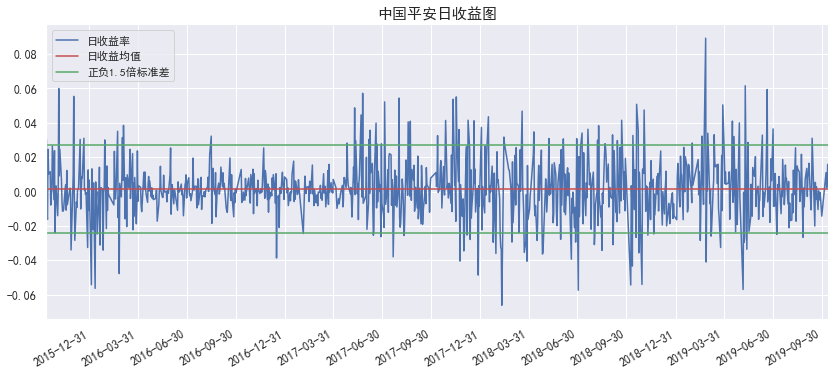

In [23]:
returns=df.close.pct_change().dropna()
returns.plot(figsize=(14,6),label='日收益率')
plt.title('中国平安日收益图',fontsize=15)
my_ticks = pd.date_range('2015-10-1','2019-10-11',freq='q')
plt.xticks(my_ticks,fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('',fontsize=12)
# 将右边 上边的两条边颜色设置为空 其实就相当于抹掉这两条边
plt.axhline(returns.mean(), color='r',label='日收益均值')
plt.axhline(returns.mean()+1.5*returns.std(), color='g',label='正负1.5倍标准差')
plt.axhline(returns.mean()-1.5*returns.std(), color='g')
plt.legend()
ax = plt.gca()  
ax.spines['right'].set_color('none') 
ax.spines['top'].set_color('none')    
plt.show()

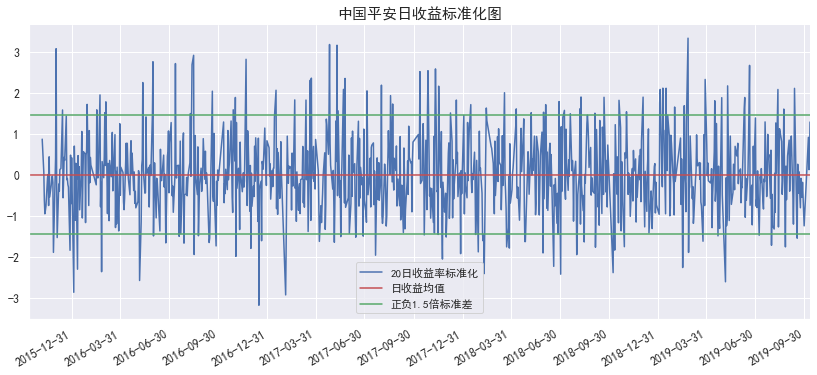

In [24]:
ret_20=returns.rolling(20).mean()
std_20=returns.rolling(20).std()
score=((returns-ret_20)/std_20)
score.plot(figsize=(14,6),label='20日收益率标准化')
plt.title('中国平安日收益标准化图',fontsize=15)
my_ticks = pd.date_range('2015-10-1','2019-10-11',freq='q')
plt.xticks(my_ticks,fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('',fontsize=12)
# 将右边 上边的两条边颜色设置为空 其实就相当于抹掉这两条边
plt.axhline(score.mean(), color='r',label='日收益均值')
plt.axhline(score.mean()+1.5*score.std(), color='g',label='正负1.5倍标准差')
plt.axhline(score.mean()-1.5*score.std(), color='g')
plt.legend()
ax = plt.gca()  
ax.spines['right'].set_color('none') 
ax.spines['top'].set_color('none')    
plt.show()

# 策略设计与回测

## 加载数据

In [121]:
#获取数据
def data_feed(stock,start='20151009',end=''):
    #获取个股数据
    df=get_data(stock,start,end)[['open','close','low','high','vol']]
    #指数数据,作为参照指标
    df['hs300']=get_data('沪深300',start,end).close.pct_change()
    #计算收益率
    df['rets']=df.close.pct_change().dropna()
    return df.dropna()

## 交易策略

计算日收益率的滚动20日score值，当score小于-1.5并且第二天开盘没有涨停时，在第二天开盘买入；当score大于1.5且第二天开盘没有跌停时，在第二天开盘卖出，每次都是全仓买卖。

In [122]:
def MR_Strategy(df,lookback=20,buy_threshold=-1.5,sell_threshold=1.5,cost=0.0):
    '''输入参数：
    df为数据表: 包含open,close,low,high,vol，标的收益率rets，指数收益率数据hs300
    lookback为均值回归策略参数，设置统计区间长度，默认20天
    buy_threshold:买入参数，均值向下偏离标准差的倍数，默认-1.5
    sell_threshold:卖出参数，均值向上偏离标准差的倍数，默认1.5
    cost为手续费+滑点价差，可以根据需要进行设置，默认为0.0
    '''
    #计算均值回归策略的score值
    ret_lb=df.rets.rolling(lookback).mean()
    std_lb=df.rets.rolling(lookback).std()
    df['score']=(df.rets-ret_lb)/std_lb
    df.dropna(inplace=True)
    #设计买卖信号，为尽量贴近实际，加入涨跌停不能买卖的限制
    #当score值小于-1.5且第二天开盘没有涨停发出买入信号设置为1
    df.loc[(df.score<buy_threshold) &(df['open'] < df['close'].shift(1) * 1.097), 'signal'] = 1
    #当score值大于1.5且第二天开盘没有跌停发出卖入信号设置为0
    df.loc[(df.score>sell_threshold) &(df['open'] > df['close'].shift(1) * 0.903), 'signal'] = 0
    df['position']=df['signal'].shift(1)
    df['position'].fillna(method='ffill',inplace=True)
    df['position'].fillna(0,inplace=True)
    #根据交易信号和仓位计算策略的每日收益率
    df.loc[df.index[0], 'capital_ret'] = 0
    #今天开盘新买入的position在今天的涨幅(扣除手续费)
    df.loc[df['position'] > df['position'].shift(1), 'capital_ret'] = \
                         (df['close'] / df['open']-1) * (1- cost) 
    #卖出同理
    df.loc[df['position'] < df['position'].shift(1), 'capital_ret'] = \
                   (df['open'] / df['close'].shift(1)-1) * (1-cost) 
    # 当仓位不变时,当天的capital是当天的change * position
    df.loc[df['position'] == df['position'].shift(1), 'capital_ret'] = \
                        df['rets'] * df['position']
    #计算标的、策略、指数的累计收益率
    df['capital_line']=(df.capital_ret+1.0).cumprod()
    df['rets_line']=(df.rets+1.0).cumprod()
    df['hs300_line']=(df.hs300+1.0).cumprod()
    return df

In [123]:
d0=data_feed('中国平安')
d1=MR_Strategy(d0)
d1.tail()

,open,close,low,high,vol,hs300,rets,score,signal,position,capital_ret,capital_line,rets_line,hs300_line
trade_date,,,,,,,,,,,,,,
2019-10-08,87.14,88.00,87.10,88.72,405313.09,0.006069,0.011029,0.926984,NaN,1.0,0.011029,1.980505,2.719961,1.035540
2019-10-09,87.44,88.18,87.33,88.60,360580.49,0.001449,0.002045,0.137398,NaN,1.0,0.002045,1.984556,2.725525,1.037040
2019-10-10,88.19,88.50,87.51,88.65,340927.32,0.008170,0.003629,0.299658,NaN,1.0,0.003629,1.991758,2.735416,1.045513
2019-10-11,88.89,89.90,88.50,90.27,600475.59,0.009572,0.015819,1.299992,NaN,1.0,0.015819,2.023266,2.778688,1.055520
2019-10-14,90.80,90.45,90.18,91.45,630443.09,0.010613,0.006118,0.547968,NaN,1.0,0.006118,2.035644,2.795688,1.066722


## 计算策略的评价指标

In [124]:
# 根据每次买入的结果,计算相关指标
#关掉pandas的warnings
pd.options.mode.chained_assignment = None
def trade_indicators(df):
    # 计算资金曲线
    df['capital'] = (df['capital_ret'] + 1).cumprod()
    df=df.reset_index()
    # 记录买入或者加仓时的日期和初始资产
    df.loc[df['position'] > df['position'].shift(1), 'start_date'] = df['trade_date']
    df.loc[df['position'] > df['position'].shift(1), 'start_capital'] = df['capital'].shift(1)
    df.loc[df['position'] > df['position'].shift(1), 'start_stock'] = df['close'].shift(1)
    # 记录卖出时的日期和当天的资产
    df.loc[df['position'] < df['position'].shift(1), 'end_date'] = df['trade_date']
    df.loc[df['position'] < df['position'].shift(1), 'end_capital'] = df['capital']
    df.loc[df['position'] < df['position'].shift(1), 'end_stock'] = df['close']
    # 将买卖当天的信息合并成一个dataframe
    df_temp = df[df['start_date'].notnull() | df['end_date'].notnull()]

    df_temp['end_date'] = df_temp['end_date'].shift(-1)
    df_temp['end_capital'] = df_temp['end_capital'].shift(-1)
    df_temp['end_stock'] = df_temp['end_stock'].shift(-1)

    # 构建账户交易情况dataframe：'hold_time'持有天数，
    #'trade_return'该次交易盈亏,'stock_return'同期股票涨跌幅
    trade = df_temp.loc[df_temp['end_date'].notnull(), ['start_date', 'start_capital', 'start_stock',
                                                       'end_date', 'end_capital', 'end_stock']]
    trade['hold_time'] = (trade['end_date'] - trade['start_date']).dt.days
    trade['trade_return'] = trade['end_capital'] / trade['start_capital'] - 1
    trade['stock_return'] = trade['end_stock'] / trade['start_stock'] - 1

    trade_num = len(trade)  # 计算交易次数
    max_holdtime = trade['hold_time'].max()  # 计算最长持有天数
    average_change = trade['trade_return'].mean()  # 计算每次平均涨幅
    max_gain = trade['trade_return'].max()  # 计算单笔最大盈利
    max_loss = trade['trade_return'].min()  # 计算单笔最大亏损
    total_years = (trade['end_date'].iloc[-1] - trade['start_date'].iloc[0]).days / 365
    trade_per_year = trade_num / total_years  # 计算年均买卖次数

    # 计算连续盈利亏损的次数
    trade.loc[trade['trade_return'] > 0, 'gain'] = 1
    trade.loc[trade['trade_return'] < 0, 'gain'] = 0
    trade['gain'].fillna(method='ffill', inplace=True)
    # 根据gain这一列计算连续盈利亏损的次数
    rtn_list = list(trade['gain'])
    successive_gain_list = []
    num = 1
    for i in range(len(rtn_list)):
        if i == 0:
            successive_gain_list.append(num)
        else:
            if (rtn_list[i] == rtn_list[i - 1] == 1) or (rtn_list[i] == rtn_list[i - 1] == 0):
                num += 1
            else:
                num = 1
            successive_gain_list.append(num)
    # 将计算结果赋给新的一列'successive_gain'
    trade['successive_gain'] = successive_gain_list
    # 分别在盈利和亏损的两个dataframe里按照'successive_gain'的值排序并取最大值
    max_successive_gain = trade[trade['gain'] == 1].sort_values(by='successive_gain', \
                        ascending=False)['successive_gain'].iloc[0]
    max_successive_loss = trade[trade['gain'] == 0].sort_values(by='successive_gain', \
                        ascending=False)['successive_gain'].iloc[0]
    
    #  输出账户交易各项指标
    print ('\n==============每笔交易收益率及同期股票涨跌幅===============')
    print (trade[['start_date', 'end_date', 'trade_return', 'stock_return']])
    print ('\n====================账户交易的各项指标=====================')
    print ('交易次数为：%d   最长持有天数为：%d' % (trade_num, max_holdtime))
    print ('每次平均涨幅为：%f' % average_change)
    print ('单次最大盈利为：%f  单次最大亏损为：%f' % (max_gain, max_loss))
    print ('年均买卖次数为：%f' % trade_per_year)
    print ('最大连续盈利次数为：%d  最大连续亏损次数为：%d' % (max_successive_gain, max_successive_loss))
    return trade

In [125]:
def performance(df):
    df1 = df.loc[:,['rets','hs300', 'capital_ret']]
    # 计算每一年(月,周)股票,资金曲线的收益
    year_ret = df1.resample('A').apply(lambda x: (x + 1.0).prod() - 1.0)
    month_ret = df1.resample('M').apply(lambda x: (x + 1.0).prod() - 1.0)
    week_ret = df1.resample('W').apply(lambda x: (x + 1.0).prod() - 1.0)
    #去掉缺失值
    year_ret.dropna(inplace=True)
    month_ret.dropna(inplace=True)
    week_ret.dropna(inplace=True)
    # 计算策略的年（月，周）胜率
    year_win_rate = len(year_ret[year_ret['capital_ret'] > 0]) / len(year_ret[year_ret['capital_ret'] != 0])
    month_win_rate = len(month_ret[month_ret['capital_ret'] > 0]) / len(month_ret[month_ret['capital_ret'] != 0])
    week_win_rate = len(week_ret[week_ret['capital_ret'] > 0]) / len(week_ret[week_ret['capital_ret'] != 0])
  
    
    total_ret=df[['capital_line','rets_line','hs300_line']].iloc[-1]-1
    annual_ret=pow(1+total_ret,250/len(df1))-1
    dd=(df[['capital_line','rets_line','hs300_line']].cummax()-\
        df[['capital_line','rets_line','hs300_line']])/\
        df[['capital_line','rets_line','hs300_line']].cummax()
    d=dd.max()
    beta=df[['capital_ret','hs300']].cov().iat[0,1]/df['hs300'].var()
    alpha=(annual_ret['capital_line']-annual_ret['hs300_line']*beta)
    exReturn=df['capital_ret']-0.03/250
    sharper_atio=np.sqrt(len(exReturn))*exReturn.mean()/exReturn.std()
    TA1=round(total_ret['capital_line']*100,2)
    TA2=round(total_ret['rets_line']*100,2)
    TA3=round(total_ret['hs300_line']*100,2)
    AR1=round(annual_ret['capital_line']*100,2)
    AR2=round(annual_ret['rets_line']*100,2)
    AR3=round(annual_ret['hs300_line']*100,2)
    MD1=round(d['capital_line']*100,2)
    MD2=round(d['rets_line']*100,2)
    MD3=round(d['hs300_line']*100,2)
    S=round(sharper_atio,2)
    
    print (f'策略年胜率为：{round(year_win_rate*100,2)}%' )
    print (f'策略月胜率为：{round(month_win_rate*100,2)}%' )
    print (f'策略周胜率为：{round(week_win_rate*100,2)}%' )
    #print(f'年累计收益率{year_ret}')
    #print(f'月累计收益率{month_ret}')
    #print(f'周累计收益率{week_ret}')
    print(f'总收益率：  策略{TA1}%，股票{TA2}%, 指数{TA3}%')
    print(f'年化收益率：策略{AR1}%, 股票{AR2}%，指数{AR3}%')
    print(f'最大回撤：  策略{MD1}%, 股票{MD2}%，指数{MD3}%')
    print(f'策略Alpha： {round(alpha,2)}, Beta：{round(beta,2)}，夏普比率：{S}')
    #return alpha,beta,sharper_atio,total_ret,annual_ret,d

In [141]:
def plot_strategy_signal(df,trade,stock):
    #对K线图和唐奇安通道进行可视化
    from pyecharts import Grid,Kline,Bar,Overlap,EffectScatter
    grid = Grid()
    attr=[str(t) for t in df.index.strftime('%Y%m%d')]
    v1=np.array(df.loc[:,['open','close','low','high']])
    kline = Kline(stock+"买卖信号",title_text_size=15)
    kline.add("K线图", attr, v1.round(1),is_datazoom_show=True,)
    # 成交量
    bar = Bar()
    bar.add("成交量", attr, df['vol'],tooltip_tragger="axis", is_legend_show=False, 
        is_yaxis_show=False, yaxis_max=5*max(df["vol"]))
    #添加买卖信号
    buy_date=trade['start_date'].apply(lambda x:pd.to_datetime(x).strftime('%Y%m%d')).values
    sell_date=trade['end_date'].apply(lambda x:pd.to_datetime(x).strftime('%Y%m%d')).values
    buy_close=trade.start_stock.values
    sell_close=trade.end_stock.values
    es = EffectScatter("buy")
    es.add( "sell", sell_date, sell_close, )
    es.add("buy",  buy_date, buy_close,symbol="triangle",)
    
    overlap = Overlap(width=2000, height=600)
    overlap.add(kline)
    overlap.add(bar,yaxis_index=1, is_add_yaxis=True)
    overlap.add(es)

    grid.add(overlap, grid_right="10%")
    return grid

In [142]:
def plot_performance(df,stock):
    d1=df[['rets_line','capital_line','hs300_line']].copy()
    d1=d1.rename(columns={'rets_line':'标的累计净值','capital_line':'策略累计净值','hs300_line':'沪深300指数累计净值'})
    d1.plot(figsize=(15,7))
    plt.title(stock+'均值回复交易策略回测',size=15)
    plt.xlabel('')
    ax=plt.gca()
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    plt.show()

回测标的：中国平安
回测期间：20151009—20191011

==============每笔交易收益率及同期股票涨跌幅===============
    start_date   end_date  trade_return  stock_return
16  2015-11-30 2015-12-03      0.054617      0.062943
21  2015-12-07 2015-12-15      0.014286      0.008871
37  2015-12-29 2016-02-01     -0.155182     -0.172830
74  2016-02-26 2016-03-03      0.031370      0.049032
123 2016-05-09 2016-05-13      0.005099      0.010190
156 2016-06-27 2016-07-13      0.046194      0.040052
180 2016-07-29 2016-08-10      0.001848      0.002772
193 2016-08-17 2016-09-20      0.033013      0.033413
220 2016-09-27 2016-10-31      0.004965      0.006689
242 2016-11-03 2016-11-22      0.035270      0.043629
262 2016-12-01 2017-01-17     -0.007703     -0.009634
303 2017-02-06 2017-02-21      0.030497      0.032285
346 2017-04-10 2017-04-26      0.000273      0.024861
365 2017-05-08 2017-05-11      0.068169      0.067365
391 2017-06-15 2017-07-06      0.068447      0.088540
418 2017-07-24 2017-08-02      0.052418      0.040032
502

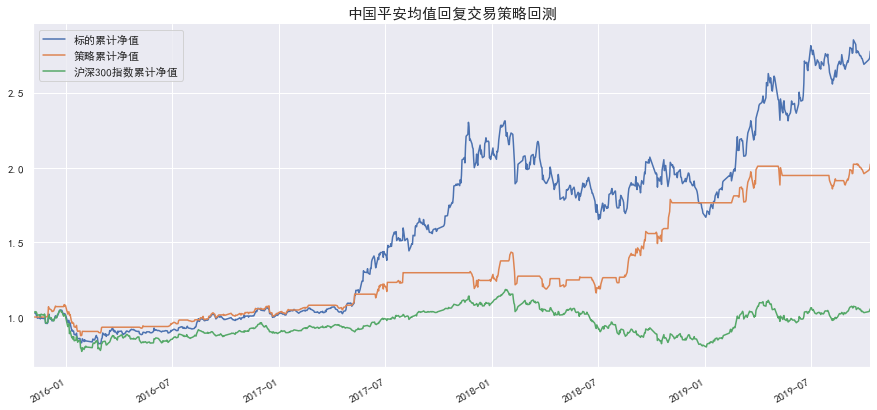

In [143]:
def main(stock,start,end):
    d0=data_feed(stock,start,end)
    d1=MR_Strategy(d0)
    print(f'回测标的：{stock}')
    print(f'回测期间：{start}—{end}')
    trade=trade_indicators(d1)
    performance(d1)
    plot_performance(d1,stock)
    return d1,trade
stock='中国平安'
d1,trade=main(stock,'20151009','20191011')
plot_strategy_signal(d1,trade,stock)

回测标的：奥马电器
回测期间：20151009—20191011

==============每笔交易收益率及同期股票涨跌幅===============
    start_date   end_date  trade_return  stock_return
3   2015-12-02 2016-01-07     -0.199505     -0.240107
29  2016-01-08 2016-01-15     -0.135067     -0.132707
59  2016-02-26 2016-03-18      0.116351      0.224488
97  2016-04-21 2016-06-01     -0.064731     -0.100438
132 2016-06-14 2016-07-07      0.220421      0.189495
152 2016-07-12 2016-08-16     -0.028572     -0.028123
205 2016-09-27 2016-10-10      0.056347      0.074408
223 2016-10-28 2016-11-24      0.130240      0.133073
255 2016-12-13 2016-12-19      0.087416      0.091938
279 2017-01-17 2017-02-22      0.062401      0.048953
310 2017-03-08 2017-04-25     -0.221468     -0.218481
395 2017-07-12 2017-09-15      0.106497      0.064514
425 2017-10-31 2017-11-29     -0.148373     -0.151261
451 2017-12-06 2017-12-07      0.027467      0.041799
474 2018-01-09 2018-01-11      0.064127      0.069861
492 2018-02-02 2018-02-28      0.190232      0.245607
516

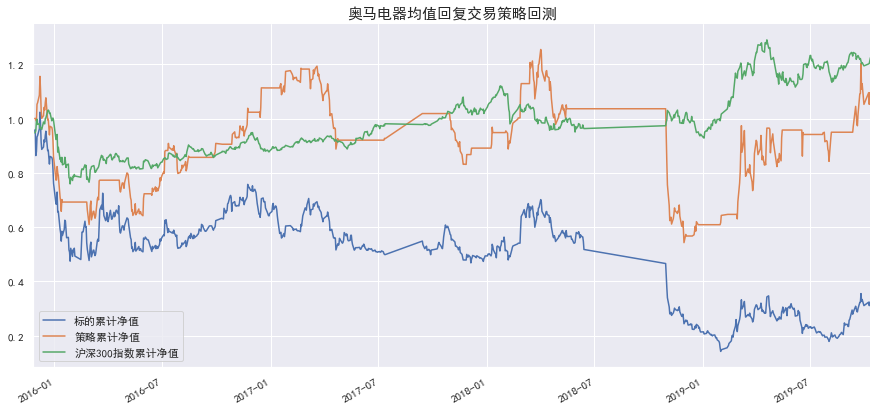

In [144]:
stock='奥马电器'
d1,trade=main(stock,'20151009','20191011')
plot_strategy_signal(d1,trade,stock)

回测标的：九州通
回测期间：20151009—20191011

==============每笔交易收益率及同期股票涨跌幅===============
    start_date   end_date  trade_return  stock_return
16  2015-11-30 2015-12-31      0.089429      0.068703
41  2016-01-05 2016-02-01     -0.072812     -0.076235
74  2016-02-26 2016-03-02     -0.042955     -0.025535
97  2016-03-30 2016-03-31      0.027780      0.035986
124 2016-05-10 2016-06-29      0.049819      0.056018
182 2016-08-02 2016-09-05      0.103585      0.102680
213 2016-09-14 2016-10-21      0.005893     -0.017621
244 2016-11-07 2016-12-19     -0.070995     -0.077389
303 2017-02-17 2017-03-27      0.026550      0.016965
368 2017-05-24 2017-06-08      0.058203      0.042516
382 2017-06-15 2017-06-22      0.011194      0.016788
392 2017-06-29 2017-06-30      0.024333      0.051707
426 2017-08-16 2017-08-23      0.019724      0.016342
436 2017-08-30 2017-08-31      0.019210      0.034346
473 2017-10-27 2017-12-08     -0.122041     -0.110334
515 2017-12-26 2018-01-25     -0.018269     -0.025298
539 

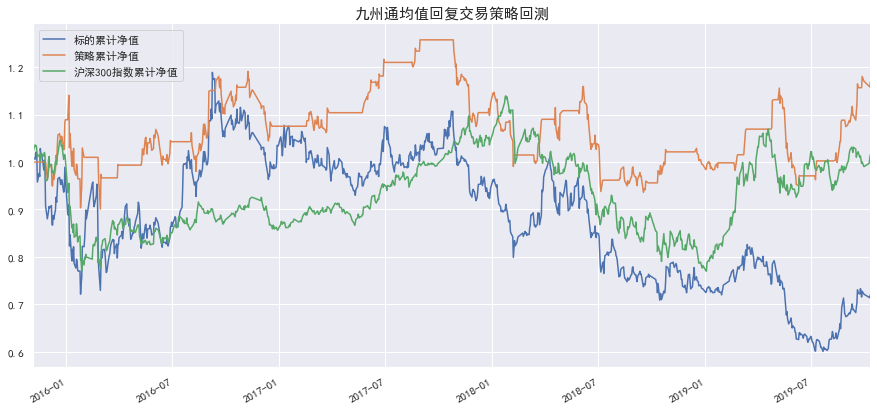

In [146]:
stock='九州通'
d1,trade=main(stock,'20151009','20191011')
plot_strategy_signal(d1,trade,stock)